In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np

#also need: igraph, leidenalg

# Load in Data
We are using single-cell RNA sequencing (scRNA-seq) data. scRNA-seq is a popular technique for measuring gene expression at the single-cell level.

**The Technique:**
- Individual cells are isolated and captured
- RNA is extracted from each cell, converted to complementary DNA (cDNA), and amplified to generate squencing libraries
- the cDNA libraries are sequenced to generate the transcriptome of each cell - which genes are expressed at at which levels

**The Data:**
- Gene expression matrix: the expression levels of genes in individual cells. Each row is a gene and each column is a cell.
- Barcodes: each cell is associated with a unique barcode that allows researchers to track expression profiles back to specific cells
- Genes: Information about genes detected in the cells (names, identifiers, expression levels)

## [Stroke Data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174574)

In [2]:
# Load in stroke data sample 1: MCA01

# Load the data into an AnnData object
adata_stroke1 = anndata.read_mtx("stroke_data/GSM5319990_MCAO1_matrix.mtx.gz")

# Read the barcode and gene files
barcodes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_barcodes.tsv.gz", header=None)
genes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_genes.tsv.gz", header=None)

In [3]:
# Set the barcodes and genes as row and column names for MCA01
adata_stroke1.obs_names = genes_stroke1[0]
adata_stroke1.var_names = barcodes_stroke1[0]

In [4]:
# Load in stroke control data sample 1: sham1

# Load the data into an AnnData object
adata_sham1 = anndata.read_mtx("stroke_data/GSM5319987_sham1_matrix.mtx.gz")

# Read the barcode and gene files
barcodes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_barcodes.tsv.gz", header=None)
genes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_genes.tsv.gz", header=None)

In [5]:
# Set the barcodes and genes as row and column names for sham1
adata_sham1.obs_names = genes_sham1[0]
adata_sham1.var_names = barcodes_sham1[0]

## [Alzheimer's Data](https://bmbls.bmi.osumc.edu/scread/)

# Stroke vs. Control

## Pre-processing: normalization, scaling, dimensionality reduction
- Normalize the gene expression counts across cells to ensure that differences in expression levels between cells are due to biological factors, not technical factors, like sequencing depth
- Apply a logarithmic transformation to the data, which is common in scRNA-seq analysis to make the data more normally distributed
- Scale the data to ensure each gene's expression values have a mean of 0 and standard deviation of 1. This is important for PCA and clustering because it prevents genes with larger expression values from dominating the analysis.

In [6]:
# Pre-process the stroke data
sc.pp.normalize_total(adata_stroke1, target_sum=1e4) # normalize the total counts
sc.pp.log1p(adata_stroke1) # apply a logarithmic transformation
sc.pp.scale(adata_stroke1) # scale

# Pre-process the control data
sc.pp.normalize_total(adata_sham1, target_sum=1e4)
sc.pp.log1p(adata_sham1)
sc.pp.scale(adata_sham1)

/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


## Cell-type Composition Comparison
- Perform PCA on the pre-processed data to reduce its dimensionality. Identify the principal components (linear combinations of genes) that capture the most variance in the data
- Construct a k-nearest neighbors (kNN) graph, which represents the similarity between cells in the lower-dimensional space, using the Uniform Manifold Approximation and Projection (UMAP) method (a non-linear dimensionality reduction technique that preservs and local and global structure in the data, which is good for high-dimensional scRNA-seq data visualized in 2D)
- Apply the Leiden clustering algorithm to partition the cells into clusters based on their connectivity in the graph
- Compute and plot the UMAP embeddings, coloring each cell based on its assigned cluster identified by the Leiden algorithm.

In [7]:
# Perform clustering to identify cell populations
sc.pp.pca(adata_stroke1, n_comps=50) # pca to reduce the dimensionality
# sc.pp.neighbors(adata_stroke1)
sc.pp.neighbors(adata_stroke1, method='umap') # construct kNN graph via UMAP method
# sc.tl.leiden(adata_stroke1)
sc.tl.leiden(adata_stroke1, flavor='igraph', n_iterations=2) # apply Leiden alg for clustering

sc.pp.pca(adata_sham1, n_comps=50)
# sc.pp.neighbors(adata_sham1)
sc.pp.neighbors(adata_sham1, method='umap')
# sc.tl.leiden(adata_sham1)
sc.tl.leiden(adata_sham1, flavor='igraph', n_iterations=2)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


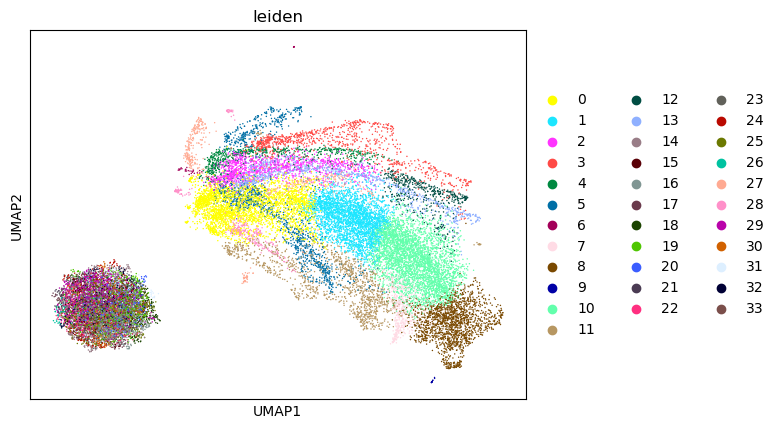

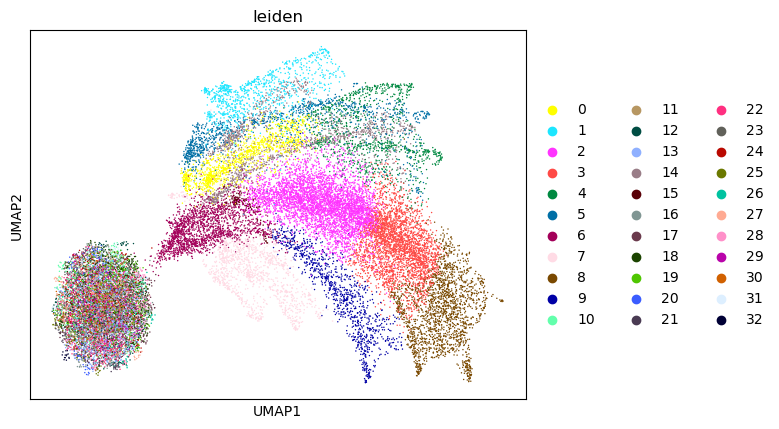

In [8]:
# Visualize cell-type compositions
sc.tl.umap(adata_stroke1)  # Compute UMAP embeddings
sc.tl.umap(adata_sham1)

sc.pl.umap(adata_stroke1, color='leiden')
sc.pl.umap(adata_sham1, color='leiden')

## Gene Expression Comparison

In [9]:
# Filter out low-expression genes
sc.pp.filter_genes(adata_stroke1, min_counts=1) 
sc.pp.filter_genes(adata_sham1, min_counts=1) 

# Perform log transformation
sc.pp.log1p(adata_stroke1)
sc.pp.log1p(adata_sham1)

# Optimize DataFrame construction: join all the columns at once instead of one by one
# pd.concat([adata_stroke1.stats[group_name, "names"], adata_stroke1.var_names[global_indices]], axis=1)
# pd.concat([adata_sham1.stats[group_name, "names"], adata_sham1.var_names[global_indices]], axis=1)

/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
# Differential gene expression analysis
sc.tl.rank_genes_groups(adata_stroke1, 'leiden')
sc.tl.rank_genes_groups(adata_sham1, 'leiden')

ZeroDivisionError: float division by zero

In [ ]:
# Visualize differentially expressed genes
sc.pl.rank_genes_groups(adata_stroke1)
sc.pl.rank_genes_groups(adata_sham1)